# Activity 2.3 Bias-Variance in Regression
In this activity we practice the bias-variance analysis in the linear regression setting.

## Data
Let's start with generating a synthetic data set. To do so, we generate a one dimensional variable `x` with uniformly scattered values in range `[-0.3, 0.3]`.

In [1]:
x = (-300:300)/1000 # 1-dimensional points
N = length(x)       # number of points

Now, we need two auxiliary functions `f` and `g` to generate labels based on the true model and the observed target (which are the true target values plus some Gaussian noises). Note that the regressor does not aware of the true model `f` and only observe `g` outputs. In the followings, `h` and `sd` are the observed target value and the standard deviation of the added noise, respectively.

In [2]:
f <- function(x) sin(5*pi*x)/(1+2*x)                       # generated true targets
g <- function(x, sd=0.01) f(x) + rnorm(length(x),sd=sd)    # generates observed values by adding Gaussian noise to true values
h = g(x, sd=0.1)                                           # observed values

In the below figure, the solid line shows `f` or the true model whereas dots show the observations (`h`). Because of the noise, dots may not be located exactly on the solid line

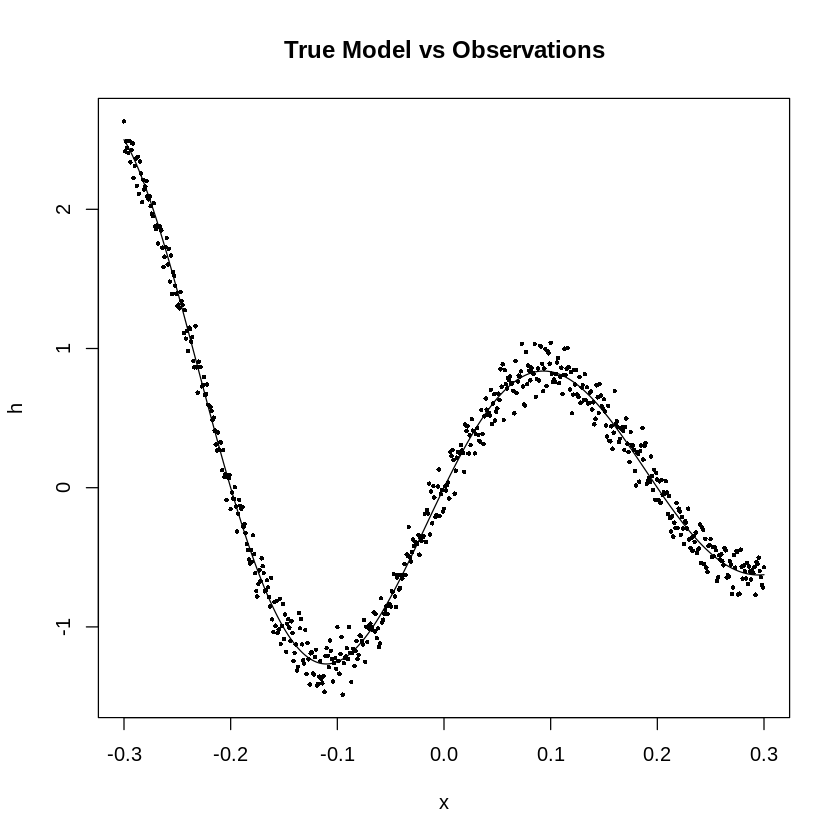

In [3]:
# Let's plot it!
plot(x, h, pch = 16, col='black', cex=.5, main="True Model vs Observations"); lines(x,f(x))

To have `m` models with different degrees of complexity, we expand the feature space (the 1-dimensional `x`) by simply computing higher degree polynomials of `x` values. Function `poly` helps us to compute these values. Each column of `X` corresponds to one of these dimensions.

In [4]:
poly <- function(x, m=1){  
    
    # This function takes a dataset and creates m polynomials for the value passed with X0 always being 1.
    # It effectively creates a formula of the type 1 + x^1 + x^2 ... + x^m
    
    # Let's start with a dataframe that has only one column and N rows all equal to 1.
    X = as.data.frame(matrix(1, nrow=N, ncol=1))  # X0 will always be 1 because x^0 = 1
    names(X) <- 'x0'      

    # If m<2 then the only values being returned is x^0 = 1 . 
    if (m<2) return (X)   
                        
    for (i in 1:m){  
        x.i <- as.data.frame(x^i)           # Create a dataframe of x^i to represent the polynomial
        names(x.i) <- paste('x',i, sep='')  # Update the name of the column to xi i.e. x1, x2...etc
        X = cbind(X, x.i)                   # Merge the new dataframe in with the existing dataframe X
    }
    return (X)
}
X <- cbind(f=f(x), g=h, poly(x, 20))
head(X)

f,g,x0,x1,x2,x3,x4,x5,x6,x7,⋯,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.500000,2.632069,1,-0.300,0.090000,-0.02700000,0.008100000,-0.002430000,0.0007290000,-0.0002187000,⋯,-1.771470e-06,5.314410e-07,-1.594323e-07,4.782969e-08,-1.434891e-08,4.304672e-09,-1.291402e-09,3.874205e-10,-1.162261e-10,3.486784e-11
2.487255,2.416517,1,-0.299,0.089401,-0.02673090,0.007992539,-0.002389769,0.0007145410,-0.0002136477,⋯,-1.707588e-06,5.105688e-07,-1.526601e-07,4.564536e-08,-1.364796e-08,4.080741e-09,-1.220142e-09,3.648223e-10,-1.090819e-10,3.261548e-11
2.474026,2.488116,1,-0.298,0.088804,-0.02646359,0.007886150,-0.002350073,0.0007003217,-0.0002086959,⋯,-1.645807e-06,4.904505e-07,-1.461542e-07,4.355396e-08,-1.297908e-08,3.867766e-09,-1.152594e-09,3.434731e-10,-1.023550e-10,3.050179e-11
2.460320,2.442029,1,-0.297,0.088209,-0.02619807,0.007780828,-0.002310906,0.0006863390,-0.0002038427,⋯,-1.586065e-06,4.710613e-07,-1.399052e-07,4.155184e-08,-1.234090e-08,3.665247e-09,-1.088578e-09,3.233077e-10,-9.602240e-11,2.851865e-11
2.446144,2.405513,1,-0.296,0.087616,-0.02593434,0.007676563,-0.002272263,0.0006725898,-0.0001990866,⋯,-1.528301e-06,4.523770e-07,-1.339036e-07,3.963546e-08,-1.173210e-08,3.472701e-09,-1.027919e-09,3.042642e-10,-9.006219e-11,2.665841e-11
2.431506,2.492237,1,-0.295,0.087025,-0.02567237,0.007573351,-0.002234138,0.0006590708,-0.0001944259,⋯,-1.472455e-06,4.343744e-07,-1.281404e-07,3.780143e-08,-1.115142e-08,3.289669e-09,-9.704525e-10,2.862835e-10,-8.445363e-11,2.491382e-11


## Model Fitting and Visualization
Now, we try to fit several models with different degrees of complexity, and compare them against the true model `f` and the observations `y` (produced by `g(.)`). 

Note that we build a few models for each degree of complexity to have a population of errors instead of only one sample. This will help us to study the uncertainty in the prediction and perform the bias-variance analysis. Indeed the statement `indx <- sort(sample(1:N, subset.size, replace = TRUE))` in the inner loop works as a bootstrap sampler where `subset.size` is the size of the selected samples (note that we sort the index only for the visualization purposes).

For this part, we use a simple but fast implementation of linear regression `lm`. In the followings, `m` corresponds to model complexity (or more percisely the degree of the polynomial).

The following code procudes one plot for each model complexity. The black line in the plots indicates the true (generative) model `f`, while each red line belongs to a model that is trained using the selected samples. The blue lines in each graph correspond to the average of the prediction obtained by the trained models (while the model complexity is fixed).

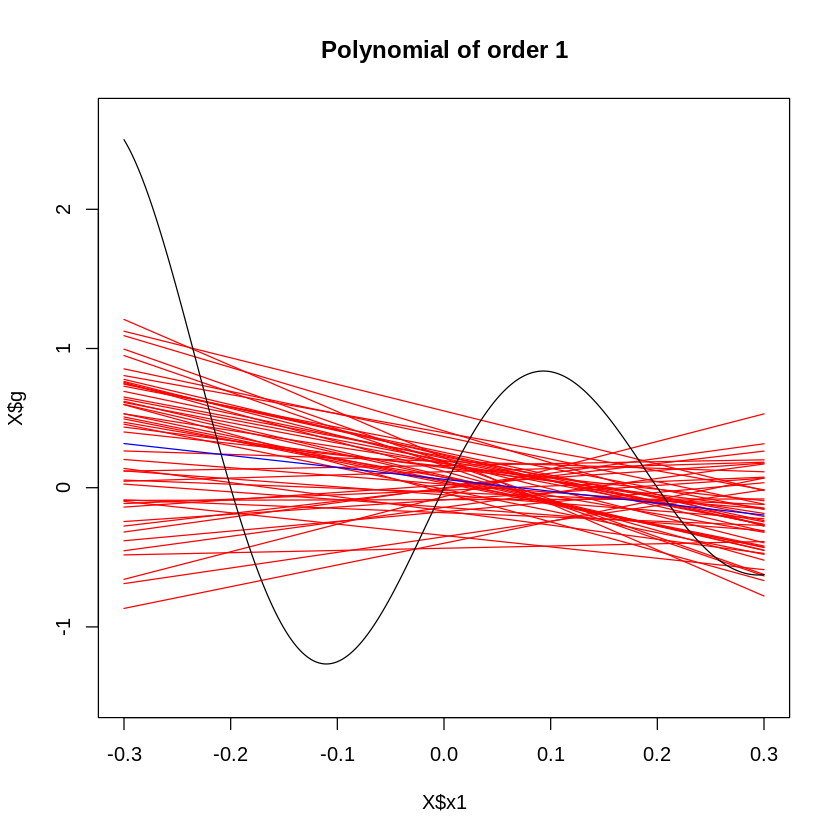

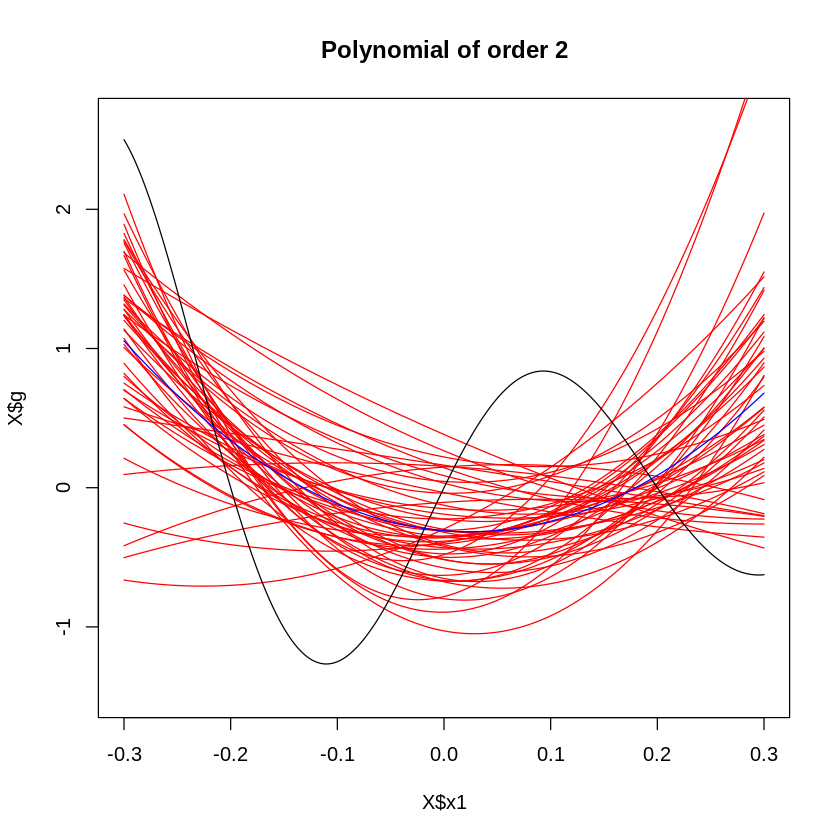

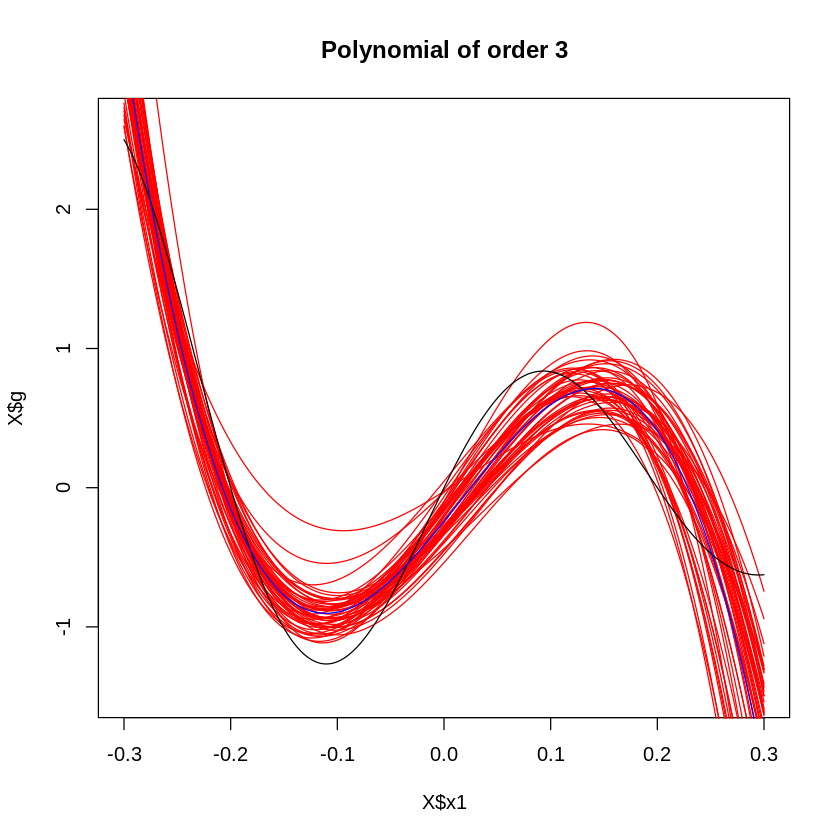

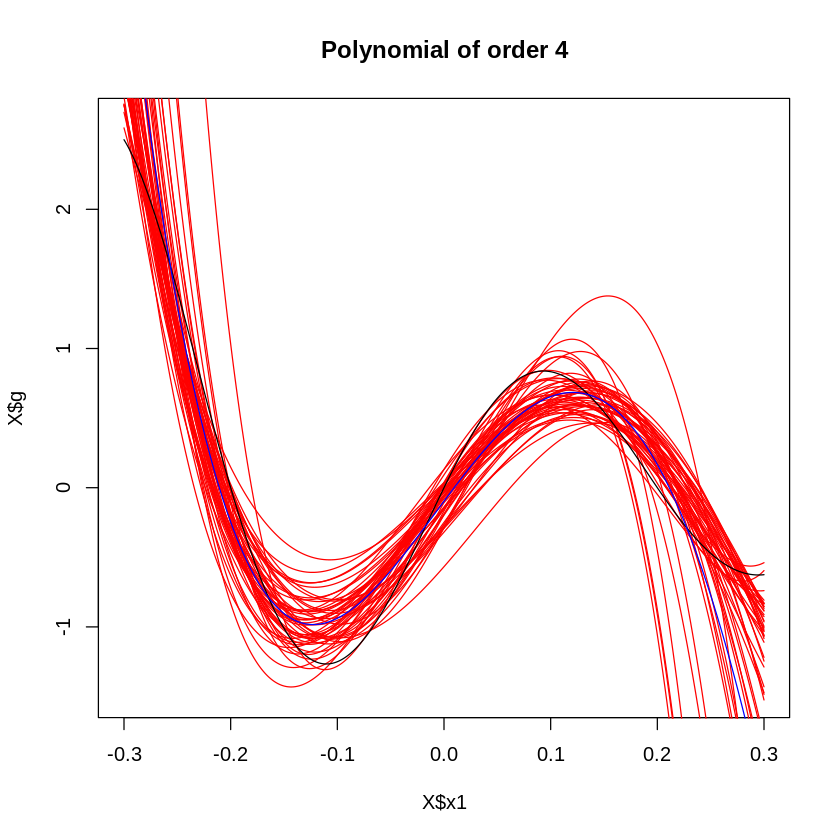

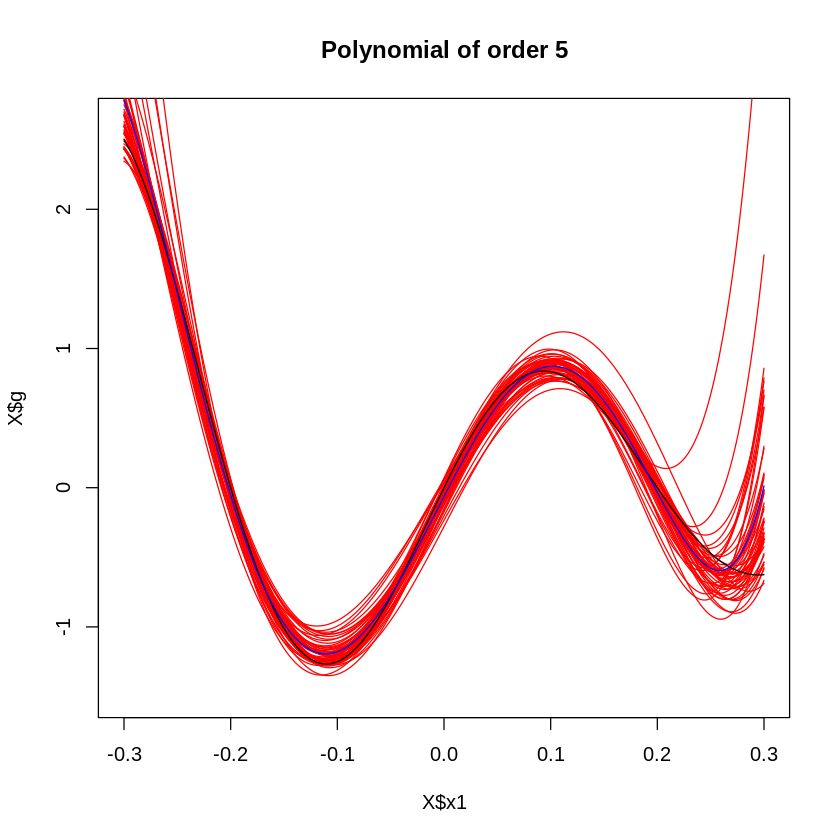

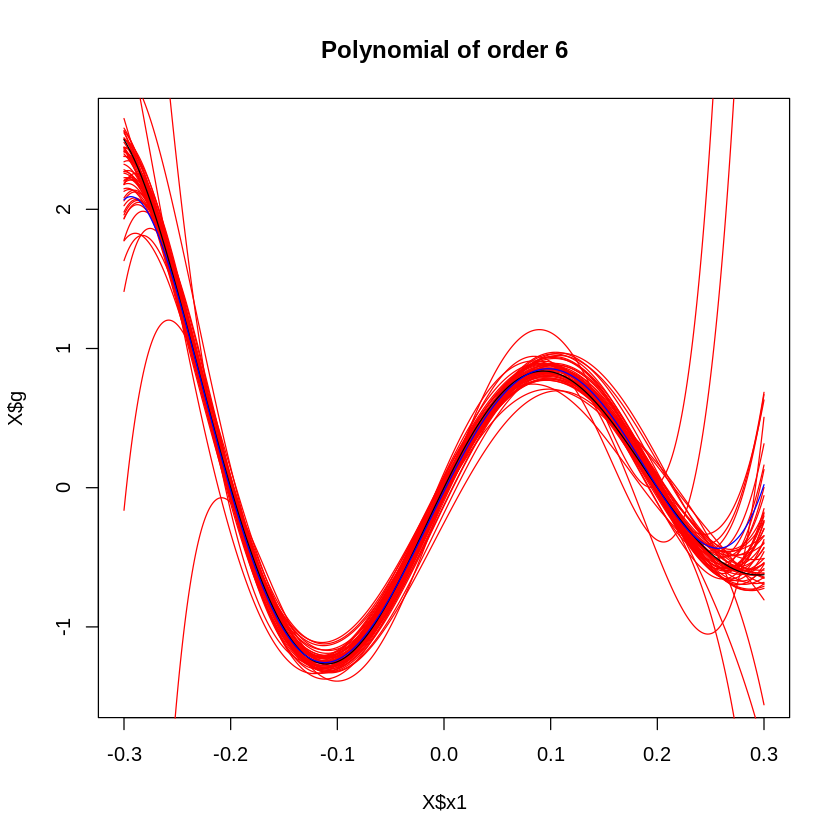

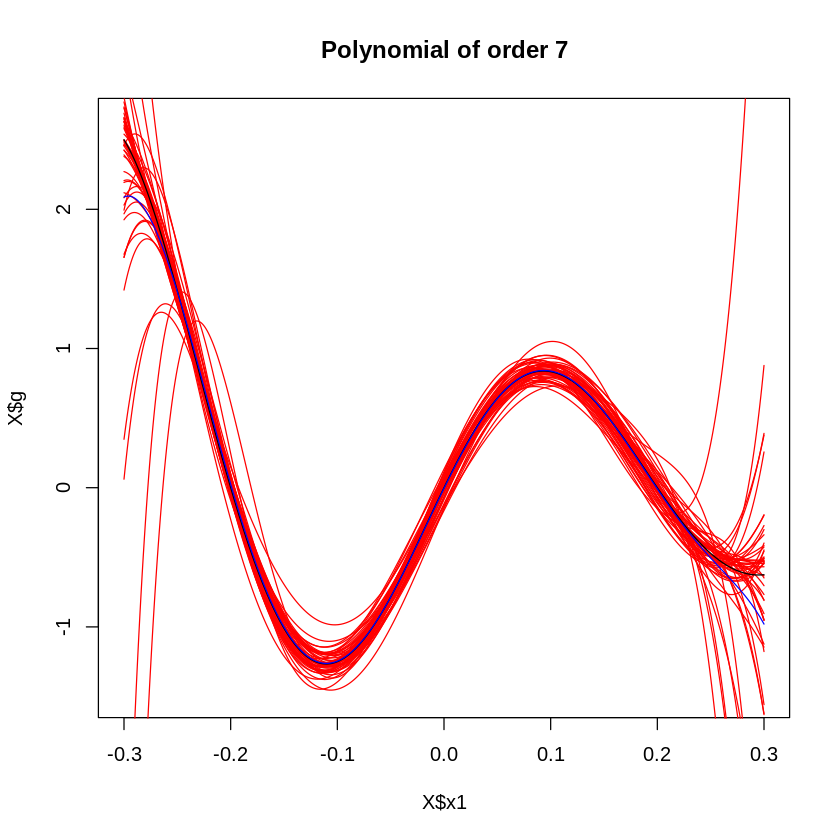

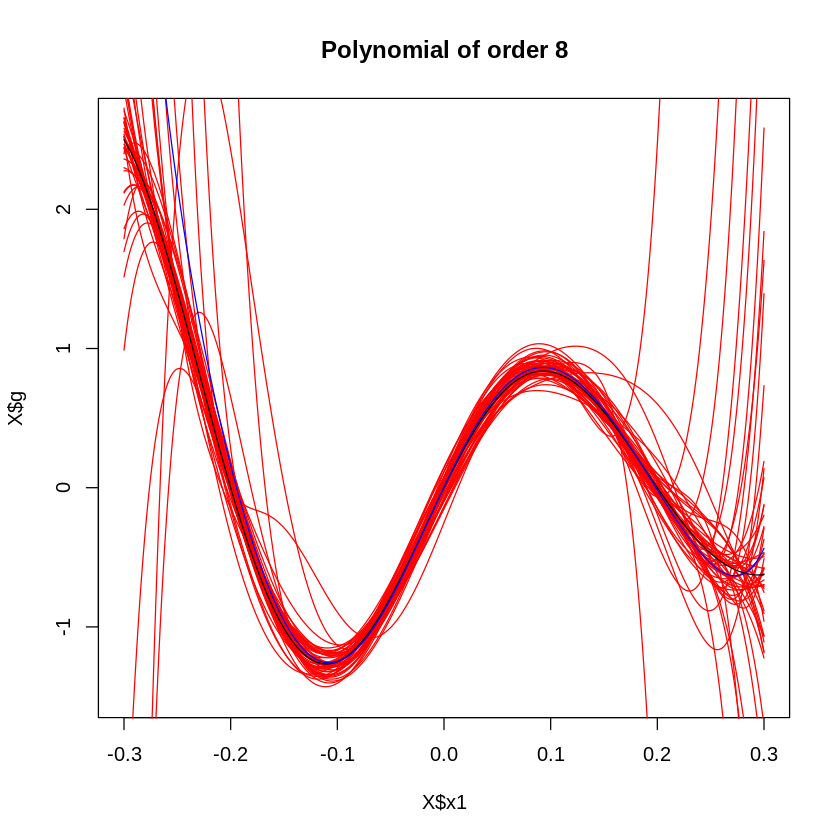

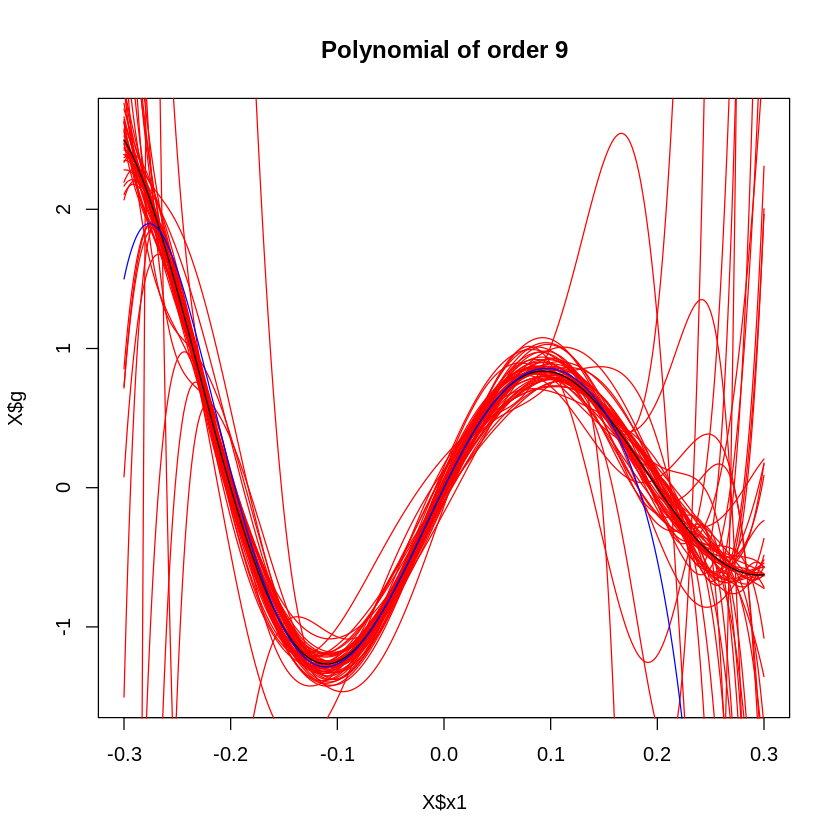

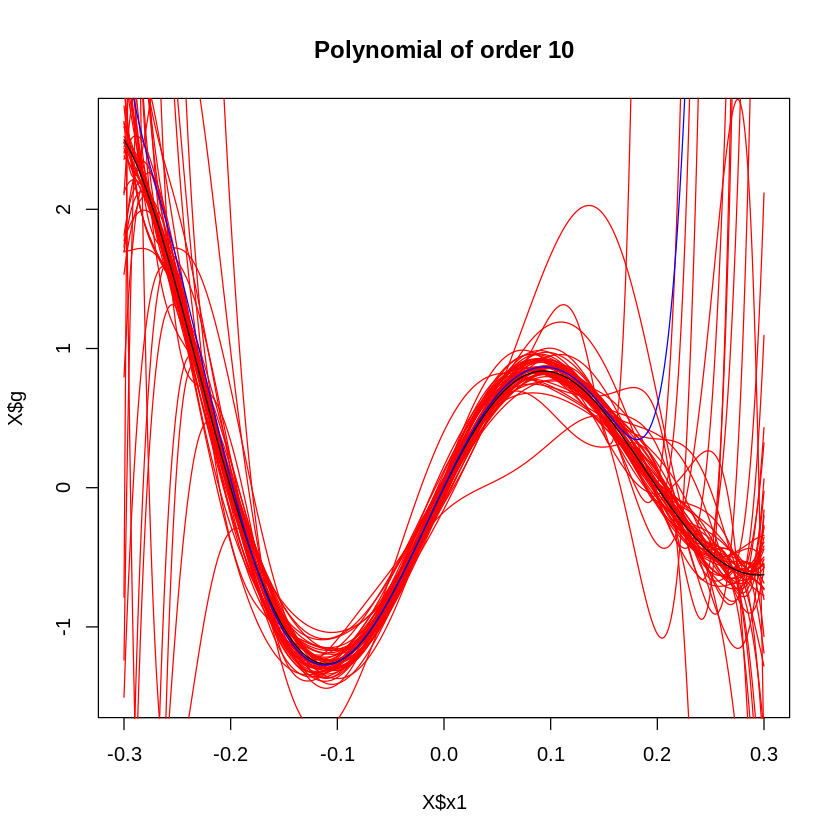

In [8]:
# trun warnings off! (warnings are produced when the sampled training data does not cover the space well...
#(known as Rank Deficiency))
options(warn=-1)

# set sample size and the number of trials
subset.size = 20
subset.num  = 50

# for each degree of polynomial (model complexity):
for (m in c(1:10)){
    y <- 0
    
    ## plot the observations - This is a plot of x^1 (i.e. x) and the observed values g 
    plot(X$x1, X$g, pch = 16, col='white', cex=.5, main=paste('Polynomial of order', m))
    
    ## build subset.num modles while the complexity is fixed but the selected samples for training may vary:
    ## Create a series of bootstrap samples from 1:subset.num (i.e. 1:100) of size subset.size (i.e. 20). 
    ## Effectively this means we will create 100 plots based on replaced samples from our training set.
    
    for (i in 1:subset.num){
        
        ### select subset.size samles from the training set using replacement
        ### here N is the size of the training set from above. 
        indx <- sort(sample(1:N, subset.size, replace = TRUE))
        
        ### fit a linear model
        lm.fit <- lm(paste('g ~', paste('x',0:m, sep='', collapse = '+')), data=X[indx,])
        
        ### add the fitted model to the plot
        y <- y + predict(lm.fit, newdata=X)  # y is cumulative here so that the average y can be calculated
                                             ## note that predict(lm.fit, newdata=X) returns a y value for every x value 
                                             ## so this is actually a vector of results and not a single number.
        lines(X$x1, predict(lm.fit, newdata=X), col='red')  ## add the red line to the graph one at a time
    }
    ## add the true model to the plot
    lines(X$x1, X$f, type='l', col='black')
    lines(X$x1, y/subset.num, type='l', col='blue')  # after the loop is done, compute the average y at each x value
    
    
} # Done!

As `m` increases the blue line (average prediction) is getting shape and become more similar to the black line. The difference between the blue line and the black line indicates how biassed our model is. In contrast, the difference between the red lines (individual predictions) and the blue line (average of the red lines) grows as `m` increases. The prediction uncertatinty can be measured by the average difference between these red lines and the blue line.

## Discussions
Study the above figures and then answer the following questions:

1- The very first figures (associated with small polynomial degrees) show the learnt models with complexities lower than the true  model complexity (the black curve) which lead to large errors. What do we call models with this property (in Bias-Variance terminology)? Are they examples of under-fitting or over-fitting situation?

2- The very last figures (associated with very large polynomial degrees) show the learnt models with complexities much higher than the true  model complexity. It seems that the models try to reflect all variations in the data (which may come from the noise in `g` than the true model `f`). What do we call such models? Are they examples of under-fitting or over-fitting situation?

3- Among the examined model complexities (value of `m`), which one is the best one? The best model here is the one which is (in average) close enough to the true model, and at the same time, is robust (as apposed to have high uncertainy in predictions).

## Bias-Variance Decomposition
In the above section, we visually studied some models with different complexities. Now, we intend to perform the bias-variance decomposition. This means, we decompose the error for each model into Bias<sup>2</sup> and Variance terms. Then, we plot these terms against the model complexity (i.e., `m`).

Let's start with setting the parameters and some initializations.

In [22]:
# set sample size and the number of bootsrapping trials

D = 30  # the number of samples in each selected dataset
L = 100 # number of datasets 
M <- 7  # maximum degree of polynomials 

# create training and testing sets
train.set <- seq(1,N,10)       # training set (we choose every tenth point as training data)
train.N   <- length(train.set) # number of samples in the trainin set
test.N    <- N - train.N       # number of testing samples

# Create empty matrix to record result in each sampling iteration. We are looking to record a value of y for 
# every test data in a single matrix. That means we end up creating test.N columns.

# The matrix has a row for each degree polynomial (M) and each dataset (L) sample so we can record the result
# of each variation of M*L. 

# This matrix has test.N+2 cols to allow for values for m and l to be included:
y <- data.frame(matrix(0,nrow=L*M, ncol=test.N+2))  

names(y) <- c('m', 'l',  paste('y',1:(test.N), sep=''))  # update the names for the y values
y$m <- rep(1:M, 1, each = L)  # add the m column which is 1:7 repeated 100 times
y$l <- rep(1:L, M, each = 1)  # add the l column which is 1:7


In the outter loop, we create `L` datasets. For each of these datasets, we fix the points and build `M` models using the training set. Then, the prediction (of testing set) obtained by each model is stored in the `y` dataframe.

In [23]:
for (l in 1:L){ # for each dataset - we're testing it L times (i.e. 100 times)
    
    indx <- sample(train.set, D, replace = TRUE) # select a single random sample of D records from the training set
    
    for (m in c(1:M)){ # for each degree of polynomial (model complexity - m)...
        
        lm.fit <- lm(paste('g ~', paste('x',1:m, sep='', collapse = '+')), data=X[indx,]) # fit a linear model
        
        ## Update the value of y for that value of m and l in the empty y matrix created earlier
        ## this is done for EVERY test value. Hence we set newdata = X[-train.set] which is test.N values
        ## Fill all values except l and m with the predictions for each model for the test data 
        y[y$m==m & y$l==l, -c(1,2)] <- predict(lm.fit, newdata=X[-train.set,]) # save the predictions
    }   
}



Almost done! The only thing remaind is to calculate Bias<sup>2</sup> and Variance terms. As we discussed in the previous chapter, Bias<sup>2</sup> is the average of differences between the true model `f` and the average of the predictins `y.bar`. Variance, as always, is the average of differences between the predictions (`y`) and their average (`y.bar`).

In [24]:
y.bar <- aggregate(y, list(y$m),mean)
y.bar <- as.matrix(y.bar[,-c(1:3)])

error <- matrix(0,nrow=M)
bias2 <- matrix(0,nrow=M)
variance <- matrix(0,nrow=M)

for (m in c(1:M)){
    bias2[m]    <- mean((y.bar[m,] - X[-train.set, 'f'])^2)                #  average sum of (y.bar - f)^2
    variance[m] <- mean(unlist((y[y$m==m,-c(1,2)]-y.bar[m,])^2))           # average sum of (y - y.bar)^2
    error[m]    <- mean(unlist((y[y$m==m,-c(1,2)]-X[-train.set, 'f'])^2))  # average sum of (y - f)^2 
} 

OK! Let's plot these values.

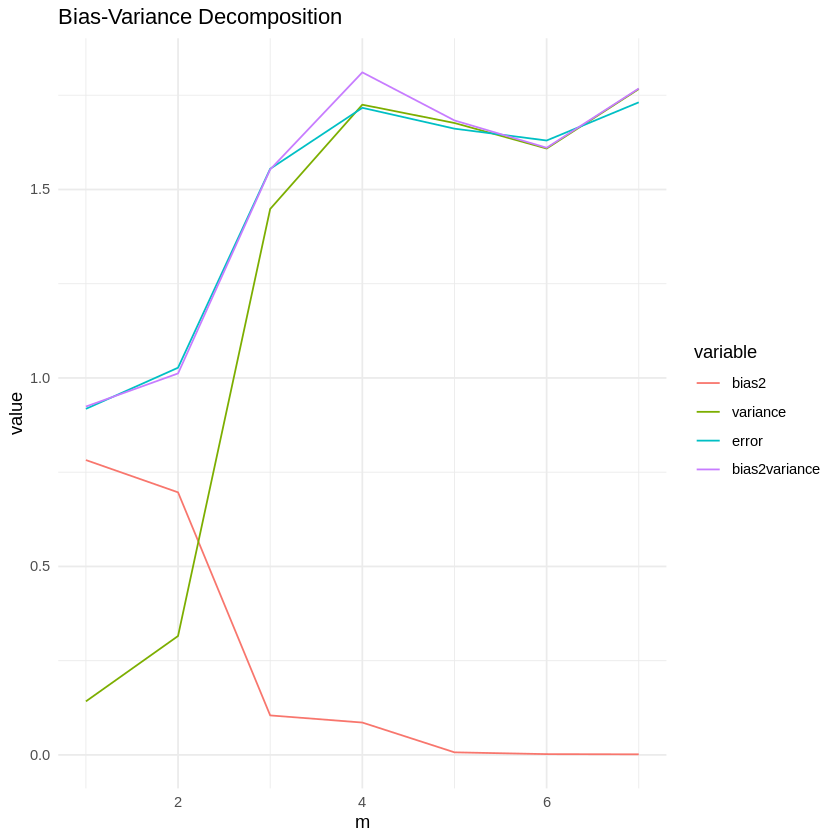

In [25]:
library(ggplot2)
library(reshape2)
dat <- as.data.frame(cbind(1:M, bias2=bias2, variance, error, bias2+variance))  # bind the errors and include a new term for bias+variance
names(dat) <- c('m', 'bias2', 'variance', 'error', 'bias2variance')
dat.m <- melt(dat, id='m')
ggplot(data=dat.m, aes(x=m, y=value, color=variable)) + 
    geom_line() + 
    labs(title='Bias-Variance Decomposition') +  
    theme_minimal()

## Discussions
Study the above figure and answer the following questions:

1- What is the relationship between the ploynomial degree (`m`) and the Bias<sup>2</sup> and Variance?

2- What is the relationship betwenn Bias<sup>2</sup> and Variance values and testing error?

3- How does Bias<sup>2</sup>-Variance Decomposition figure explain the model figures we have produced at the first part of the experiments?